In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
import random
import pandas as pd
from scipy.io import savemat
import scipy
import matplotlib.cm as cm
from utils import *

In [2]:
# experimental task
def task(freq_seq, lm, hm, s, n_trials = 10, n_tones = 3, p_low = 0.5, p_back = 0.3):
    log_freq_seq_mid = np.median(exptFreqSeqArray)
    log_freq_low = [lm,s]#[log_freq_seq_mid - 0.15,0.1]  #low freq condition is gaussian 
    log_freq_high = [hm,s]#[log_freq_seq_mid + 0.15,0.1] #high freq condition is gaussian
    trial_tones = []
    dist_chosen = np.array([])
    kind_of_tones = []

    for trial in range(n_trials):
        signal_rand = np.random.random()
        low_dist = signal_rand < p_low #choosing true tone from either low or high condition
        tones = []
        tone_kind = []
        for n_tone in range(n_tones):
            signal_back = np.random.random()
            background = signal_back < p_back #choosing background or true tone
            if background:
                nearest_log_tone = np.random.choice(exptFreqSeqArray)
                #background freq is chosen from a uniform distribution
                tone_kind.append(0)
            else: 
                if low_dist:
                    tone = min(max(np.random.randn()*log_freq_low[1] + log_freq_low[0],\
                                   exptFreqSeqArray[0]),exptFreqSeqArray[-1])                    
                    tone_kind.append(1)
                else:
                    tone = min(max(np.random.randn()*log_freq_high[1] + log_freq_high[0],\
                                   exptFreqSeqArray[0]),exptFreqSeqArray[-1])
                    tone_kind.append(2)
                nearest_log_tone = exptFreqSeqArray[np.argmin(np.abs(exptFreqSeqArray - tone))]
            nearest_tone = freq_seq[np.argmin(np.abs(freq_seq - 10**nearest_log_tone))]        
            tones.append(nearest_tone)
        trial_tones.append(tones)
        dist_chosen = np.append(dist_chosen, 1-low_dist)
        kind_of_tones.append(tone_kind)
    return trial_tones, dist_chosen, kind_of_tones, log_freq_low, log_freq_high

In [3]:
freqSeq = np.arange(90,3000,1) #array of possible true tones
exptFreqSeqArray = np.arange(np.log10(freqSeq[0]), np.log10(freqSeq[-1]), np.log10(1003/1000)*40)
logFreqBins = exptFreqSeqArray[np.arange(1,len(exptFreqSeqArray),2)]#(exptFreqSeqArray[:-1]+exptFreqSeqArray[1:])/2
expt_freq_seq_mid = np.median(exptFreqSeqArray)
low_dist = [expt_freq_seq_mid - 0.15,0.1]
high_dist = [expt_freq_seq_mid + 0.15,0.1]

isubj = 0
averageBehaviorAcrossSubjects_low = np.zeros((30,1))
averageBehaviorAcrossSubjects_high = np.zeros((30,1))

    
def trialCategories(trial_tones, trial_behaviour, corrans, trial_tones_kind):
    """
    dividing trials into different categories : 
    1. all trials with tones from gaussian distributions
    2. all trials with one tone as distractor from extremes
    3. all trials with one tone as distractor from gaussian distribution
    4. all trials with two tones as distractor from opp extremes
    5. all trials with two tones as distractors (one from opp and other from same side extreme)
    
    These will be stored in arrays where the first 3 columns are the tones. 4th is the subject's behaviour.
    5th is the correct answer.
    6th and 7th is optimal subject's reponses given the strategy of taking an average of all the tones.
    8th and 9th is optimal subject's responses given the strategy of ignoring the distractor tones and taking 
    an average of the remaining tones.
    10th is optimal subject's responses given the strategy of taking majority category (i.e. 2 out of 3).
    11th and 12th is optimal subject's responses given the strategy of using only the 
    highest tone for classification.
    
    As of 04-27 I think that pback=1 in the model corresponds to taking an average over all the tones 
    (because in that case we think that each of the tones has signal in it). However taking pback=0 in the model 
    corresponds to the other two cases, because when pback = 0 for a particular tone it implies that the tone 
    does not give information about the category
    """
    
    allGaussLow = np.zeros((len(trial_behaviour),13))
    allGaussHigh = np.zeros((len(trial_behaviour),13))
    distGaussHigh = np.zeros((len(trial_behaviour),13))
    distGaussLow = np.zeros((len(trial_behaviour),13))
    distLowOtherLow = np.zeros((len(trial_behaviour),13))
    distLowOtherHigh = np.zeros((len(trial_behaviour),13))
    distHighOtherLow = np.zeros((len(trial_behaviour),13))
    distHighOtherHigh = np.zeros((len(trial_behaviour),13))
    distLowOtherLowHigh = np.zeros((len(trial_behaviour),13))
    distHighOtherLowHigh = np.zeros((len(trial_behaviour),13))
    distTwoExtrOtherGauss = np.zeros((len(trial_behaviour),13))
    distTwoExtrSameGauss = np.zeros((len(trial_behaviour),13))
    distThreeExtr = np.zeros((len(trial_behaviour),13))
    distThreeExtrTwoSame = np.zeros((len(trial_behaviour),13))
    zeroDistractors = np.zeros((len(trial_behaviour),8))
    oneDistractor = np.zeros((len(trial_behaviour),8))
    twoDistractors = np.zeros((len(trial_behaviour),8))
    threeDistractors = np.zeros((len(trial_behaviour),8))
    nonzeroDistractors = np.zeros((len(trial_behaviour),5))
    
    n_tones = len(trial_tones[0])
    print(high_dist[0]+2*high_dist[1], 
          low_dist[0]-2*low_dist[1], 
          expt_freq_seq_mid)
    
    iAllGaussLow = 0; iAllGaussHigh = 0; iDistGaussHigh = 0; iDistGaussLow = 0; iDistLowOtherLow = 0; 
    iDistLowOtherHigh = 0; iDistHighOtherLow = 0; iDistHighOtherHigh = 0; iDistLowOtherLowHigh = 0;
    iDistHighOtherLowHigh = 0; iDistTwoExtrOtherGauss = 0; iDistTwoExtrSameGauss = 0; iDistThreeExtr = 0; 
    iDistThreeExtrTwoSame = 0; 
    iZeroDistractors = 0; iOneDistractor = 0; iTwoDistractors = 0; iThreeDistractors = 0; iNonZeroDistractors = 0
    
    for i_trial in range(len(trial_tones)):
        if (sum(trial_tones[i_trial]<expt_freq_seq_mid)==3 
            & sum(trial_tones[i_trial]>(low_dist[0]-2*low_dist[1]))==3):
            allGaussLow[iAllGaussLow,:3] = trial_tones[i_trial,:]
            allGaussLow[iAllGaussLow,3] = trial_behaviour[i_trial]
            allGaussLow[iAllGaussLow,4] = corrans[i_trial]
            allGaussLow[iAllGaussLow,5] = np.mean(allGaussLow[iAllGaussLow,:3])
            allGaussLow[iAllGaussLow,6] = allGaussLow[iAllGaussLow,5] > expt_freq_seq_mid 
            allGaussLow[iAllGaussLow,7] = allGaussLow[iAllGaussLow,5]
            allGaussLow[iAllGaussLow,8] = allGaussLow[iAllGaussLow,6]
            allGaussLow[iAllGaussLow,9] = allGaussLow[iAllGaussLow,6]
            allGaussLow[iAllGaussLow,10] = np.max(trial_tones[i_trial,:]) 
            allGaussLow[iAllGaussLow,11] = allGaussLow[iAllGaussLow,10] > expt_freq_seq_mid
            allGaussLow[iAllGaussLow,12] = int(i_trial)
            iAllGaussLow += 1
            
        elif (sum(trial_tones[i_trial]>expt_freq_seq_mid)==3 
              & sum(trial_tones[i_trial]<(high_dist[0]+2*high_dist[1]))==3): 
            allGaussHigh[iAllGaussHigh,:3] = trial_tones[i_trial,:]
            allGaussHigh[iAllGaussHigh,3] = trial_behaviour[i_trial]
            allGaussHigh[iAllGaussHigh,4] = corrans[i_trial]
            allGaussHigh[iAllGaussHigh,5] = np.mean(allGaussHigh[iAllGaussHigh,:3])
            allGaussHigh[iAllGaussHigh,6] = allGaussHigh[iAllGaussHigh,5] > expt_freq_seq_mid 
            allGaussHigh[iAllGaussHigh,7] = allGaussHigh[iAllGaussHigh,5]
            allGaussHigh[iAllGaussHigh,8] = allGaussHigh[iAllGaussHigh,6]
            allGaussHigh[iAllGaussHigh,9] = allGaussHigh[iAllGaussHigh,6]  
            allGaussHigh[iAllGaussHigh,10] = np.max(trial_tones[i_trial,:]) 
            allGaussHigh[iAllGaussHigh,11] = allGaussHigh[iAllGaussHigh,10] > expt_freq_seq_mid
            allGaussHigh[iAllGaussHigh,12] = int(i_trial)
            iAllGaussHigh += 1
            
        elif (sum(trial_tones[i_trial]<expt_freq_seq_mid)==1
              and sum(trial_tones[i_trial]>expt_freq_seq_mid)==2
              and sum(trial_tones[i_trial]>(high_dist[0]+2*high_dist[1]))==0
              and sum(trial_tones[i_trial]<(low_dist[0]-2*low_dist[1]))==0):
            distGaussLow[iDistGaussLow,:3] = trial_tones[i_trial,:]
            distGaussLow[iDistGaussLow,3] = trial_behaviour[i_trial]
            distGaussLow[iDistGaussLow,4] = corrans[i_trial]
            distGaussLow[iDistGaussLow,5] = np.mean(distGaussLow[iDistGaussLow,:3])
            distGaussLow[iDistGaussLow,6] = distGaussLow[iDistGaussLow,5] > expt_freq_seq_mid
            distGaussLow[iDistGaussLow,7] = np.mean(trial_tones[i_trial]
                                                         [trial_tones[i_trial]>expt_freq_seq_mid])
            distGaussLow[iDistGaussLow,8] = distGaussLow[iDistGaussLow,7] > expt_freq_seq_mid
            distGaussLow[iDistGaussLow,9] = 1
            distGaussLow[iDistGaussLow,10] = np.max(trial_tones[i_trial,:]) 
            distGaussLow[iDistGaussLow,11] = distGaussLow[iDistGaussLow,10] > expt_freq_seq_mid 
            distGaussLow[iDistGaussLow,12] = int(i_trial)
            #if len(np.where(trial_tones_kind[i_trial]==0)[0])==2:
            #    print(trial_tones_kind[i_trial,:], corrans[i_trial])
            iDistGaussLow += 1
            #pdb.set_trace()    
        
        elif (sum(trial_tones[i_trial]<expt_freq_seq_mid)==2
              and sum(trial_tones[i_trial]>expt_freq_seq_mid)==1
              and sum(trial_tones[i_trial]>(high_dist[0]+2*high_dist[1]))==0 
              and sum(trial_tones[i_trial]<(low_dist[0]-2*low_dist[1]))==0):
            distGaussHigh[iDistGaussHigh,:3] = trial_tones[i_trial,:]
            distGaussHigh[iDistGaussHigh,3] = trial_behaviour[i_trial]
            distGaussHigh[iDistGaussHigh,4] = corrans[i_trial]
            distGaussHigh[iDistGaussHigh,5] = np.mean(distGaussHigh[iDistGaussHigh,:3])
            distGaussHigh[iDistGaussHigh,6] = distGaussHigh[iDistGaussHigh,5] > expt_freq_seq_mid
            distGaussHigh[iDistGaussHigh,7] = np.mean(trial_tones[i_trial]
                                                         [trial_tones[i_trial]<expt_freq_seq_mid])
            distGaussHigh[iDistGaussHigh,8] = distGaussHigh[iDistGaussHigh,7] > expt_freq_seq_mid
            distGaussHigh[iDistGaussHigh,9] = 0
            distGaussHigh[iDistGaussHigh,10] = np.max(trial_tones[i_trial,:]) 
            distGaussHigh[iDistGaussHigh,11] = distGaussHigh[iDistGaussHigh,10] > expt_freq_seq_mid 
            distGaussHigh[iDistGaussHigh,12] = int(i_trial)
            #if len(np.where(trial_tones_kind[i_trial]==0)[0])==2:
            #    print(trial_tones_kind[i_trial,:], corrans[i_trial])
            iDistGaussHigh += 1
            #pdb.set_trace()    
        
        elif (sum(trial_tones[i_trial]<expt_freq_seq_mid)==3 
              and sum(trial_tones[i_trial]<(low_dist[0]-2*low_dist[1]))==1):
            distLowOtherLow[iDistLowOtherLow,:3] = trial_tones[i_trial,:]
            distLowOtherLow[iDistLowOtherLow,3] = trial_behaviour[i_trial]
            distLowOtherLow[iDistLowOtherLow,4] = corrans[i_trial]
            distLowOtherLow[iDistLowOtherLow,5] = np.mean(distLowOtherLow[iDistLowOtherLow,:3])
            distLowOtherLow[iDistLowOtherLow,6] = distLowOtherLow[iDistLowOtherLow,5] > expt_freq_seq_mid
            distLowOtherLow[iDistLowOtherLow,7] = np.mean(trial_tones[i_trial]
                                                         [trial_tones[i_trial]>(low_dist[0]-2*low_dist[1])])
            distLowOtherLow[iDistLowOtherLow,8] = distLowOtherLow[iDistLowOtherLow,7] >expt_freq_seq_mid
            distLowOtherLow[iDistLowOtherLow,9] = 0
            distLowOtherLow[iDistLowOtherLow,10] = np.max(trial_tones[i_trial,:]) 
            distLowOtherLow[iDistLowOtherLow,11] = distLowOtherLow[iDistLowOtherLow,10] > expt_freq_seq_mid 
            distLowOtherLow[iDistLowOtherLow,12] = int(i_trial)
            iDistLowOtherLow += 1
            
        elif (sum(trial_tones[i_trial]>expt_freq_seq_mid)==3 
              and sum(trial_tones[i_trial]>(high_dist[0]+2*high_dist[1]))==1):
            distHighOtherHigh[iDistHighOtherHigh,:3] = trial_tones[i_trial,:]
            distHighOtherHigh[iDistHighOtherHigh,3] = trial_behaviour[i_trial]
            distHighOtherHigh[iDistHighOtherHigh,4] = corrans[i_trial]
            distHighOtherHigh[iDistHighOtherHigh,5] = np.mean(distHighOtherHigh[iDistHighOtherHigh,:3])
            distHighOtherHigh[iDistHighOtherHigh,6] = distHighOtherHigh[iDistHighOtherHigh,5] > expt_freq_seq_mid
            distHighOtherHigh[iDistHighOtherHigh,7] = np.mean(trial_tones[i_trial]
                                                         [trial_tones[i_trial]<(high_dist[0]+2*high_dist[1])])
            distHighOtherHigh[iDistHighOtherHigh,8] = distHighOtherHigh[iDistHighOtherHigh,7] > expt_freq_seq_mid
            distHighOtherHigh[iDistHighOtherHigh,9] = 1
            distHighOtherHigh[iDistHighOtherHigh,10] = np.max(trial_tones[i_trial,:]) 
            distHighOtherHigh[iDistHighOtherHigh,11] = distHighOtherHigh[iDistHighOtherHigh,10] > expt_freq_seq_mid 
            distHighOtherHigh[iDistHighOtherHigh,12] = int(i_trial)
            iDistHighOtherHigh += 1
                
        elif (sum(trial_tones[i_trial]>expt_freq_seq_mid)==2 
              and sum(trial_tones[i_trial]>(high_dist[0]+2*high_dist[1]))==0
              and sum(trial_tones[i_trial]<(low_dist[0]-2*low_dist[1]))==1):    
            distLowOtherHigh[iDistLowOtherHigh,:3] = trial_tones[i_trial,:]
            distLowOtherHigh[iDistLowOtherHigh,3] = trial_behaviour[i_trial]
            distLowOtherHigh[iDistLowOtherHigh,4] = corrans[i_trial]
            distLowOtherHigh[iDistLowOtherHigh,5] = np.mean(distLowOtherHigh[iDistLowOtherHigh,:3])
            distLowOtherHigh[iDistLowOtherHigh,6] = distLowOtherHigh[iDistLowOtherHigh,5] > expt_freq_seq_mid
            distLowOtherHigh[iDistLowOtherHigh,7] = np.mean(trial_tones[i_trial]
                                                         [trial_tones[i_trial]>expt_freq_seq_mid])
            distLowOtherHigh[iDistLowOtherHigh,8] = distLowOtherHigh[iDistLowOtherHigh,7] > expt_freq_seq_mid
            distLowOtherHigh[iDistLowOtherHigh,9] = 1
            distLowOtherHigh[iDistLowOtherHigh,10] = np.max(trial_tones[i_trial,:]) 
            distLowOtherHigh[iDistLowOtherHigh,11] = distLowOtherHigh[iDistLowOtherHigh,10] > expt_freq_seq_mid 
            distLowOtherHigh[iDistLowOtherHigh,12] = int(i_trial)
            iDistLowOtherHigh += 1
            
        elif (sum(trial_tones[i_trial]<expt_freq_seq_mid)==2 
              and sum(trial_tones[i_trial]>(high_dist[0]+2*high_dist[1]))==1
              and sum(trial_tones[i_trial]<(low_dist[0]-2*low_dist[1]))==0):
            distHighOtherLow[iDistHighOtherLow,:3] = trial_tones[i_trial,:]
            distHighOtherLow[iDistHighOtherLow,3] = trial_behaviour[i_trial]
            distHighOtherLow[iDistHighOtherLow,4] = corrans[i_trial]
            distHighOtherLow[iDistHighOtherLow,5] = np.mean(distHighOtherLow[iDistHighOtherLow,:3])
            distHighOtherLow[iDistHighOtherLow,6] = distHighOtherLow[iDistHighOtherLow,5] > expt_freq_seq_mid
            distHighOtherLow[iDistHighOtherLow,7] = np.mean(trial_tones[i_trial]
                                                         [trial_tones[i_trial]<expt_freq_seq_mid])
            distHighOtherLow[iDistHighOtherLow,8] = distHighOtherLow[iDistHighOtherLow,7] > expt_freq_seq_mid
            distHighOtherLow[iDistHighOtherLow,9] = 0
            distHighOtherLow[iDistHighOtherLow,10] = np.max(trial_tones[i_trial,:]) 
            distHighOtherLow[iDistHighOtherLow,11] = distHighOtherLow[iDistHighOtherLow,10] > expt_freq_seq_mid 
            distHighOtherLow[iDistHighOtherLow,12] = int(i_trial)
            iDistHighOtherLow += 1
            
        elif (sum(trial_tones[i_trial]>expt_freq_seq_mid)==1 
              and sum(trial_tones[i_trial]<expt_freq_seq_mid)==2 
              and sum(trial_tones[i_trial]>(high_dist[0]+2*high_dist[1]))==0
              and sum(trial_tones[i_trial]<(low_dist[0]-2*low_dist[1]))==1):    
            distLowOtherLowHigh[iDistLowOtherLowHigh,:3] = trial_tones[i_trial,:]
            distLowOtherLowHigh[iDistLowOtherLowHigh,3] = trial_behaviour[i_trial]
            distLowOtherLowHigh[iDistLowOtherLowHigh,4] = corrans[i_trial]
            distLowOtherLowHigh[iDistLowOtherLowHigh,5] = np.mean(distLowOtherLowHigh[iDistLowOtherLowHigh,:3])
            distLowOtherLowHigh[iDistLowOtherLowHigh,6] = distLowOtherLowHigh[iDistLowOtherLowHigh,5] > expt_freq_seq_mid
            distLowOtherLowHigh[iDistLowOtherLowHigh,7] = None
            distLowOtherLowHigh[iDistLowOtherLowHigh,8] = None
            distLowOtherLowHigh[iDistLowOtherLowHigh,9] = 0
            distLowOtherLowHigh[iDistLowOtherLowHigh,10] = np.max(trial_tones[i_trial,:]) 
            distLowOtherLowHigh[iDistLowOtherLowHigh,11] = distLowOtherLowHigh[iDistLowOtherLowHigh,10] > expt_freq_seq_mid 
            distLowOtherLowHigh[iDistLowOtherLowHigh,12] = int(i_trial)
            #print('a',distLowOtherLowHigh[iDistLowOtherLowHigh,:5])
            iDistLowOtherLowHigh += 1    
            
        elif (sum(trial_tones[i_trial]>expt_freq_seq_mid)==2 
              and sum(trial_tones[i_trial]<expt_freq_seq_mid)==1 
              and sum(trial_tones[i_trial]>(high_dist[0]+2*high_dist[1]))==1
              and sum(trial_tones[i_trial]<(low_dist[0]-2*low_dist[1]))==0):    
            distHighOtherLowHigh[iDistHighOtherLowHigh,:3] = trial_tones[i_trial,:]
            distHighOtherLowHigh[iDistHighOtherLowHigh,3] = trial_behaviour[i_trial]
            distHighOtherLowHigh[iDistHighOtherLowHigh,4] = corrans[i_trial]
            distHighOtherLowHigh[iDistHighOtherLowHigh,5] = np.mean(distHighOtherLowHigh[iDistHighOtherLowHigh,:3])
            distHighOtherLowHigh[iDistHighOtherLowHigh,6] = distHighOtherLowHigh[iDistHighOtherLowHigh,5] > expt_freq_seq_mid
            distHighOtherLowHigh[iDistHighOtherLowHigh,7] = None
            distHighOtherLowHigh[iDistHighOtherLowHigh,8] = None
            distHighOtherLowHigh[iDistHighOtherLowHigh,9] = 1
            distHighOtherLowHigh[iDistHighOtherLowHigh,10] = np.max(trial_tones[i_trial,:]) 
            distHighOtherLowHigh[iDistHighOtherLowHigh,11] = distHighOtherLowHigh[iDistHighOtherLowHigh,10] > expt_freq_seq_mid 
            distHighOtherLowHigh[iDistHighOtherLowHigh,12] = int(i_trial)
            #print('a',distHighOtherLowHigh[iDistHighOtherLowHigh,:5])
            iDistHighOtherLowHigh += 1 
            
        elif (sum(trial_tones[i_trial]>(high_dist[0]+2*high_dist[1]))==2 
              and sum(trial_tones[i_trial]<expt_freq_seq_mid)==1
              and sum(trial_tones[i_trial]<(low_dist[0]-2*low_dist[1]))==0):
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,:3] = trial_tones[i_trial,:]
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,3] = trial_behaviour[i_trial]
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,4] = corrans[i_trial]
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,5] = np.mean(distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,:3])
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,6] = distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,5] > expt_freq_seq_mid
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,7] = trial_tones[i_trial][np.argmin(abs(trial_tones[i_trial]-expt_freq_seq_mid))]
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,8] = distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,7] > expt_freq_seq_mid
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,9] = sum(trial_tones[i_trial]>expt_freq_seq_mid)>1
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,10] = np.max(trial_tones[i_trial,:]) 
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,11] = distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,10] > expt_freq_seq_mid 
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,12] = int(i_trial)
            #print(distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,:3])
            iDistTwoExtrOtherGauss += 1
              
        elif (sum(trial_tones[i_trial]>(high_dist[0]+2*high_dist[1]))==0 
              and sum(trial_tones[i_trial]>expt_freq_seq_mid)==1
              and sum(trial_tones[i_trial]<(low_dist[0]-2*low_dist[1]))==2):            
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,:3] = trial_tones[i_trial,:]
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,3] = trial_behaviour[i_trial]
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,4] = corrans[i_trial]
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,5] = np.mean(distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,:3])
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,6] = distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,5] > expt_freq_seq_mid
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,7] = trial_tones[i_trial][np.argmin(abs(trial_tones[i_trial]-expt_freq_seq_mid))]
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,8] = distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,7] > expt_freq_seq_mid
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,9] = sum(trial_tones[i_trial]>expt_freq_seq_mid)>1
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,10] = np.max(trial_tones[i_trial,:]) 
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,11] = distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,10] > expt_freq_seq_mid 
            distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,12] = int(i_trial)
            #print(distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,:3])
            iDistTwoExtrOtherGauss += 1  
            
        elif (sum(trial_tones[i_trial]>(high_dist[0]+2*high_dist[1]))==0 
              and sum(trial_tones[i_trial]<expt_freq_seq_mid)==3
              and sum(trial_tones[i_trial]<(low_dist[0]-2*low_dist[1]))==2):
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,:3] = trial_tones[i_trial,:]
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,3] = trial_behaviour[i_trial]
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,4] = corrans[i_trial]
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,5] = np.mean(distTwoExtrSameGauss[iDistTwoExtrSameGauss,:3])
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,6] = distTwoExtrSameGauss[iDistTwoExtrSameGauss,5] > expt_freq_seq_mid
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,7] = trial_tones[i_trial][np.argmin(abs(trial_tones[i_trial]-expt_freq_seq_mid))]
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,8] = distTwoExtrSameGauss[iDistTwoExtrSameGauss,7] > expt_freq_seq_mid
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,9] = sum(trial_tones[i_trial]>expt_freq_seq_mid)>1
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,10] = np.max(trial_tones[i_trial,:]) 
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,11] = distTwoExtrSameGauss[iDistTwoExtrSameGauss,10] > expt_freq_seq_mid 
            #print(distTwoExtrSameGauss[iDistTwoExtrSameGauss,[0,1,2,3,4,6,8,9]])
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,12] = int(i_trial)
            iDistTwoExtrSameGauss += 1
              
        elif (sum(trial_tones[i_trial]>(high_dist[0]+2*high_dist[1]))==2
              and sum(trial_tones[i_trial]>expt_freq_seq_mid)==3
              and sum(trial_tones[i_trial]<(low_dist[0]-2*low_dist[1]))==0):            
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,:3] = trial_tones[i_trial,:]
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,3] = trial_behaviour[i_trial]
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,4] = corrans[i_trial]
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,5] = np.mean(distTwoExtrSameGauss[iDistTwoExtrSameGauss,:3])
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,6] = distTwoExtrSameGauss[iDistTwoExtrSameGauss,5] > expt_freq_seq_mid
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,7] = trial_tones[i_trial][np.argmin(abs(trial_tones[i_trial]-expt_freq_seq_mid))]
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,8] = distTwoExtrSameGauss[iDistTwoExtrSameGauss,7] > expt_freq_seq_mid
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,9] = sum(trial_tones[i_trial]>expt_freq_seq_mid)>1
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,10] = np.max(trial_tones[i_trial,:]) 
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,11] = distTwoExtrSameGauss[iDistTwoExtrSameGauss,10] > expt_freq_seq_mid 
            #print(distTwoExtrSameGauss[iDistTwoExtrSameGauss,[0,1,2,3,4,6,8,9]])
            distTwoExtrSameGauss[iDistTwoExtrSameGauss,12] = int(i_trial)
            iDistTwoExtrSameGauss += 1    
            
        elif (sum(trial_tones[i_trial]<(low_dist[0]-2*low_dist[1]))==3):
            distThreeExtr[iDistThreeExtr,:3] = trial_tones[i_trial,:]
            distThreeExtr[iDistThreeExtr,3] = trial_behaviour[i_trial]
            distThreeExtr[iDistThreeExtr,4] = corrans[i_trial]
            distThreeExtr[iDistThreeExtr,5] = np.mean(distThreeExtr[iDistThreeExtr,:3])
            distThreeExtr[iDistThreeExtr,6] = distThreeExtr[iDistThreeExtr,5] > expt_freq_seq_mid
            distThreeExtr[iDistThreeExtr,7] = None
            distThreeExtr[iDistThreeExtr,8] = None
            distThreeExtr[iDistThreeExtr,9] = sum(trial_tones[i_trial]>expt_freq_seq_mid)>1
            distThreeExtr[iDistThreeExtr,10] = np.max(trial_tones[i_trial,:]) 
            distThreeExtr[iDistThreeExtr,11] = distThreeExtr[iDistThreeExtr,10] > expt_freq_seq_mid 
            distThreeExtr[iDistThreeExtr,12] = int(i_trial)
            #print(distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,[0,1,2,3,5,6,7,8,9]])
            iDistThreeExtr += 1
              
        elif (sum(trial_tones[i_trial]>(high_dist[0]+2*high_dist[1]))==3):
            distThreeExtr[iDistThreeExtr,:3] = trial_tones[i_trial,:]
            distThreeExtr[iDistThreeExtr,3] = trial_behaviour[i_trial]
            distThreeExtr[iDistThreeExtr,4] = corrans[i_trial]
            distThreeExtr[iDistThreeExtr,5] = np.mean(distThreeExtr[iDistThreeExtr,:3])
            distThreeExtr[iDistThreeExtr,6] = distThreeExtr[iDistThreeExtr,5] > expt_freq_seq_mid
            distThreeExtr[iDistThreeExtr,7] = None
            distThreeExtr[iDistThreeExtr,8] = None
            distThreeExtr[iDistThreeExtr,9] = sum(trial_tones[i_trial]>expt_freq_seq_mid)>1
            distThreeExtr[iDistThreeExtr,10] = np.max(trial_tones[i_trial,:]) 
            distThreeExtr[iDistThreeExtr,11] = distThreeExtr[iDistThreeExtr,10] > expt_freq_seq_mid 
            distThreeExtr[iDistThreeExtr,12] = int(i_trial)
            #print(distTwoExtrOtherGauss[iDistTwoExtrOtherGauss,[0,1,2,3,5,6,7,8,9]])
            iDistThreeExtr += 1    
       
        elif (sum(trial_tones[i_trial]<(low_dist[0]-2*low_dist[1]))==2
             and sum(trial_tones[i_trial]>(high_dist[0]+2*high_dist[1]))==1):
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,:3] = trial_tones[i_trial,:]
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,3] = trial_behaviour[i_trial]
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,4] = corrans[i_trial]
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,5] = np.mean(distThreeExtrTwoSame[iDistThreeExtrTwoSame,:3])
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,6] = distThreeExtrTwoSame[iDistThreeExtrTwoSame,5] > expt_freq_seq_mid
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,7] = None
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,8] = None
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,9] = sum(trial_tones[i_trial]>expt_freq_seq_mid)>1
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,10] = np.max(trial_tones[i_trial,:]) 
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,11] = distThreeExtrTwoSame[iDistThreeExtrTwoSame,10] > expt_freq_seq_mid 
            #print(distThreeExtrTwoSame[iDistThreeExtrTwoSame,[0,1,2,3,4,5,6,7,8,9]])
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,12] = int(i_trial)
            iDistThreeExtrTwoSame += 1
              
        elif (sum(trial_tones[i_trial]>(high_dist[0]+2*high_dist[1]))==2
             and sum(trial_tones[i_trial]<(low_dist[0]-2*low_dist[1]))==1):
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,:3] = trial_tones[i_trial,:]
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,3] = trial_behaviour[i_trial]
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,4] = corrans[i_trial]
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,5] = np.mean(distThreeExtrTwoSame[iDistThreeExtrTwoSame,:3])
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,6] = distThreeExtrTwoSame[iDistThreeExtrTwoSame,5] > expt_freq_seq_mid
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,7] = None
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,8] = None
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,9] = sum(trial_tones[i_trial]>expt_freq_seq_mid)>1
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,10] = np.max(trial_tones[i_trial,:]) 
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,11] = distThreeExtrTwoSame[iDistThreeExtrTwoSame,10] > expt_freq_seq_mid 
            #print(distThreeExtrTwoSame[iDistThreeExtrTwoSame,[0,1,2,3,4,5,6,7,8,9]])
            distThreeExtrTwoSame[iDistThreeExtrTwoSame,12] = int(i_trial)
            iDistThreeExtrTwoSame += 1   

    for i_trial in range(len(trial_tones_kind)): 
        #pdb.set_trace()
        if  len(np.where(trial_tones_kind[i_trial]==0)[0])==0:
            zeroDistractors[iZeroDistractors,:3] = trial_tones[i_trial,:]
            zeroDistractors[iZeroDistractors,3] = trial_behaviour[i_trial]
            zeroDistractors[iZeroDistractors,4] = corrans[i_trial]
            zeroDistractors[iZeroDistractors,5:] = trial_tones_kind[i_trial]
            iZeroDistractors += 1               
            
        elif len(np.where(trial_tones_kind[i_trial]==0)[0])==1:
            oneDistractor[iOneDistractor,:3] = trial_tones[i_trial,:]
            oneDistractor[iOneDistractor,3] = trial_behaviour[i_trial]
            oneDistractor[iOneDistractor,4] = corrans[i_trial]
            oneDistractor[iOneDistractor,5:] = trial_tones_kind[i_trial]
            iOneDistractor += 1
            
        elif len(np.where(trial_tones_kind[i_trial]==0)[0])==2:
            twoDistractors[iTwoDistractors,:3] = trial_tones[i_trial,:]
            twoDistractors[iTwoDistractors,3] = trial_behaviour[i_trial]
            twoDistractors[iTwoDistractors,4] = corrans[i_trial]
            twoDistractors[iTwoDistractors,5:] = trial_tones_kind[i_trial]
            iTwoDistractors += 1
        
        else:
            threeDistractors[iThreeDistractors,:3] = trial_tones[i_trial,:]
            threeDistractors[iThreeDistractors,3] = trial_behaviour[i_trial]
            threeDistractors[iThreeDistractors,4] = corrans[i_trial]
            threeDistractors[iThreeDistractors,5:] = trial_tones_kind[i_trial]
            iThreeDistractors += 1
            
        if len(np.where(trial_tones_kind[i_trial]==0)[0])>0:
            nonzeroDistractors[iNonZeroDistractors,:3] = trial_tones[i_trial,:]
            nonzeroDistractors[iNonZeroDistractors,3] = trial_behaviour[i_trial]
            nonzeroDistractors[iNonZeroDistractors,4] = corrans[i_trial]
            iNonZeroDistractors += 1 
            
        """
        if ((int(low_dist[0]-2*low_dist[1]<trial_tones[i_trial][0]<expt_freq_seq_mid) +
             int(low_dist[0]-2*low_dist[1]<trial_tones[i_trial][1]<expt_freq_seq_mid) +
             int(low_dist[0]-2*low_dist[1]<trial_tones[i_trial][2]<expt_freq_seq_mid))==2):
            oneDistractor[iOneDistractor,:3] = trial_tones[i_trial,:]
            oneDistractor[iOneDistractor,3] = trial_behaviour[i_trial]
            oneDistractor[iOneDistractor,4] = corrans[i_trial]
            iOneDistractor += 1   
            
        elif ((int(expt_freq_seq_mid<trial_tones[i_trial][0]<high_dist[0]+2*high_dist[1]) +
             int(expt_freq_seq_mid<trial_tones[i_trial][1]<high_dist[0]+2*high_dist[1]) +
             int(expt_freq_seq_mid<trial_tones[i_trial][2]<high_dist[0]+2*high_dist[1]))==2):
            oneDistractor[iOneDistractor,:3] = trial_tones[i_trial,:]
            oneDistractor[iOneDistractor,3] = trial_behaviour[i_trial]
            oneDistractor[iOneDistractor,4] = corrans[i_trial]
            iOneDistractor += 1
            
        elif ((int(low_dist[0]-2*low_dist[1]<trial_tones[i_trial][0]<high_dist[0]+2*high_dist[1]) +
             int(low_dist[0]-2*low_dist[1]<trial_tones[i_trial][1]<high_dist[0]+2*high_dist[1]) +
             int(low_dist[0]-2*low_dist[1]<trial_tones[i_trial][2]<high_dist[0]+2*high_dist[1]))==1):
            twoDistractors[iTwoDistractors,:3] = trial_tones[i_trial,:]
            twoDistractors[iTwoDistractors,3] = trial_behaviour[i_trial]
            twoDistractors[iTwoDistractors,4] = corrans[i_trial]
            iTwoDistractors += 1
        """
        
    return(allGaussLow[:iAllGaussLow,:], 
           allGaussHigh[:iAllGaussHigh,:], 
           distGaussLow[:iDistGaussLow,:],
           distGaussHigh[:iDistGaussHigh,:],
           distLowOtherLow[:iDistLowOtherLow,:], 
           distHighOtherHigh[:iDistHighOtherHigh,:],
           distLowOtherHigh[:iDistLowOtherHigh,:], 
           distHighOtherLow[:iDistHighOtherLow,:],
           distLowOtherLowHigh[:iDistLowOtherLowHigh,:], 
           distHighOtherLowHigh[:iDistHighOtherLowHigh,:],
           distTwoExtrOtherGauss[:iDistTwoExtrOtherGauss,:], 
           distTwoExtrSameGauss[:iDistTwoExtrSameGauss,:],
           distThreeExtr[:iDistThreeExtr,:], 
           distThreeExtrTwoSame[:iDistThreeExtrTwoSame,:],
           zeroDistractors[:iZeroDistractors],
           nonzeroDistractors[:iNonZeroDistractors],
           oneDistractor[:iOneDistractor,:],
           twoDistractors[:iTwoDistractors,:],
           threeDistractors[:iThreeDistractors,:])


In [4]:
def accuracies(allGaussLow, allGaussHigh, distGaussLow, distGaussHigh, distLowOtherLow, 
               distHighOtherHigh, distLowOtherHigh, distHighOtherLow, distLowOtherLowHigh,
               distHighOtherLowHigh, distTwoExtrOtherGauss, distTwoExtrSameGauss, 
               distThreeExtrTwoSame, corrans_expt, trial_behaviour_expt):
    """
    Calculating accuracy table

    rows: different categories
    columns: different strategies - |ideal subject accuracy|% of trials that can be explained using a 
    given strategy| * number of strategies
    """

    accuracy = np.zeros((10, 9))
    distSameOtherSame = np.concatenate((distLowOtherLow,distHighOtherHigh),axis=0)
    distractorGaussian = np.concatenate((distGaussLow,distGaussHigh),axis=0)
    allGaussian = np.concatenate((allGaussLow,allGaussHigh),axis=0)
    biasWithUnclearSignal = np.zeros((1,5))
    
    """
    accuracy[0,0] = np.mean(allGaussLow[:,3]==allGaussLow[:,4])
    accuracy[0,1] = np.mean(allGaussLow[:,4]==allGaussLow[:,6])
    accuracy[0,2] = np.mean(allGaussLow[:,3]==allGaussLow[:,6])
    accuracy[0,3] = np.mean(allGaussLow[:,4]==allGaussLow[:,8])
    accuracy[0,4] = np.mean(allGaussLow[:,3]==allGaussLow[:,8])
    accuracy[0,5] = np.mean(allGaussLow[:,4]==allGaussLow[:,9])
    accuracy[0,6] = np.mean(allGaussLow[:,3]==allGaussLow[:,9])
    accuracy[0,7] = np.mean(allGaussLow[:,4]==allGaussLow[:,11])
    accuracy[0,8] = np.mean(allGaussLow[:,3]==allGaussLow[:,11])
    
    accuracy[1,0] = np.mean(allGaussHigh[:,3]==allGaussHigh[:,4])
    accuracy[1,1] = np.mean(allGaussHigh[:,4]==allGaussHigh[:,6])
    accuracy[1,2] = np.mean(allGaussHigh[:,3]==allGaussHigh[:,6])
    accuracy[1,3] = np.mean(allGaussHigh[:,4]==allGaussHigh[:,8])
    accuracy[1,4] = np.mean(allGaussHigh[:,3]==allGaussHigh[:,8])
    accuracy[1,5] = np.mean(allGaussHigh[:,4]==allGaussHigh[:,9])
    accuracy[1,6] = np.mean(allGaussHigh[:,3]==allGaussHigh[:,9])
    accuracy[1,7] = np.mean(allGaussHigh[:,4]==allGaussHigh[:,11])
    accuracy[1,8] = np.mean(allGaussHigh[:,3]==allGaussHigh[:,11])
    """
    accuracy[0,0] = np.mean(allGaussian[:,3]==allGaussian[:,4])
    accuracy[0,1] = np.mean(allGaussian[:,4]==allGaussian[:,6])
    accuracy[0,2] = np.mean(allGaussian[:,3]==allGaussian[:,6])
    accuracy[0,3] = np.mean(allGaussian[:,4]==allGaussian[:,8])
    accuracy[0,4] = np.mean(allGaussian[:,3]==allGaussian[:,8])
    accuracy[0,5] = np.mean(allGaussian[:,4]==allGaussian[:,9])
    accuracy[0,6] = np.mean(allGaussian[:,3]==allGaussian[:,9])
    accuracy[0,7] = np.mean(allGaussian[:,4]==allGaussian[:,11])
    accuracy[0,8] = np.mean(allGaussian[:,3]==allGaussian[:,11])
    
    accuracy[2,0] = np.mean(distractorGaussian[:,3]==distractorGaussian[:,4])
    accuracy[2,1] = np.mean(distractorGaussian[:,4]==distractorGaussian[:,6])
    accuracy[2,2] = np.mean(distractorGaussian[:,3]==distractorGaussian[:,6])
    accuracy[2,3] = np.mean(distractorGaussian[:,4]==distractorGaussian[:,8])
    accuracy[2,4] = np.mean(distractorGaussian[:,3]==distractorGaussian[:,8])
    accuracy[2,5] = np.mean(distractorGaussian[:,4]==distractorGaussian[:,9])
    accuracy[2,6] = np.mean(distractorGaussian[:,3]==distractorGaussian[:,9])
    accuracy[2,7] = np.mean(distractorGaussian[:,4]==distractorGaussian[:,11])
    accuracy[2,8] = np.mean(distractorGaussian[:,3]==distractorGaussian[:,11])
    """
    
    accuracy[2,0] = np.mean(distGaussLow[:,3]==distGaussLow[:,4])
    accuracy[2,1] = np.mean(distGaussLow[:,4]==distGaussLow[:,6])
    accuracy[2,2] = np.mean(distGaussLow[:,3]==distGaussLow[:,6])
    accuracy[2,3] = np.mean(distGaussLow[:,4]==distGaussLow[:,8])
    accuracy[2,4] = np.mean(distGaussLow[:,3]==distGaussLow[:,8])
    accuracy[2,5] = np.mean(distGaussLow[:,4]==distGaussLow[:,9])
    accuracy[2,6] = np.mean(distGaussLow[:,3]==distGaussLow[:,9])
    accuracy[2,7] = np.mean(distGaussLow[:,4]==distGaussLow[:,11])
    accuracy[2,8] = np.mean(distGaussLow[:,3]==distGaussLow[:,11])
    
    accuracy[3,0] = np.mean(distGaussHigh[:,3]==distGaussHigh[:,4])
    accuracy[3,1] = np.mean(distGaussHigh[:,4]==distGaussHigh[:,6])
    accuracy[3,2] = np.mean(distGaussHigh[:,3]==distGaussHigh[:,6])
    accuracy[3,3] = np.mean(distGaussHigh[:,4]==distGaussHigh[:,8])
    accuracy[3,4] = np.mean(distGaussHigh[:,3]==distGaussHigh[:,8])
    accuracy[3,5] = np.mean(distGaussHigh[:,4]==distGaussHigh[:,9])
    accuracy[3,6] = np.mean(distGaussHigh[:,3]==distGaussHigh[:,9])
    accuracy[3,7] = np.mean(distGaussHigh[:,4]==distGaussHigh[:,11])
    accuracy[3,8] = np.mean(distGaussHigh[:,3]==distGaussHigh[:,11])

    accuracy[4,0] = np.mean(distLowOtherLow[:,3]==distLowOtherLow[:,4])
    accuracy[4,1] = np.mean(distLowOtherLow[:,4]==distLowOtherLow[:,6])
    accuracy[4,2] = np.mean(distLowOtherLow[:,3]==distLowOtherLow[:,6])
    accuracy[4,3] = np.mean(distLowOtherLow[:,4]==distLowOtherLow[:,8])
    accuracy[4,4] = np.mean(distLowOtherLow[:,3]==distLowOtherLow[:,8])
    accuracy[4,5] = np.mean(distLowOtherLow[:,4]==distLowOtherLow[:,9])
    accuracy[4,6] = np.mean(distLowOtherLow[:,3]==distLowOtherLow[:,9])
    accuracy[4,7] = np.mean(distLowOtherLow[:,4]==distLowOtherLow[:,11])
    accuracy[4,8] = np.mean(distLowOtherLow[:,3]==distLowOtherLow[:,11])

    accuracy[5,0] = np.mean(distHighOtherHigh[:,3]==distHighOtherHigh[:,4])
    accuracy[5,1] = np.mean(distHighOtherHigh[:,4]==distHighOtherHigh[:,6])
    accuracy[5,2] = np.mean(distHighOtherHigh[:,3]==distHighOtherHigh[:,6])
    accuracy[5,3] = np.mean(distHighOtherHigh[:,4]==distHighOtherHigh[:,8])
    accuracy[5,4] = np.mean(distHighOtherHigh[:,3]==distHighOtherHigh[:,8])
    accuracy[5,5] = np.mean(distHighOtherHigh[:,4]==distHighOtherHigh[:,9])
    accuracy[5,6] = np.mean(distHighOtherHigh[:,3]==distHighOtherHigh[:,9])
    accuracy[5,7] = np.mean(distHighOtherHigh[:,4]==distHighOtherHigh[:,11])
    accuracy[5,8] = np.mean(distHighOtherHigh[:,3]==distHighOtherHigh[:,11])
    """
    accuracy[3,0] = np.mean(distSameOtherSame[:,3]==distSameOtherSame[:,4])
    accuracy[3,1] = np.mean(distSameOtherSame[:,4]==distSameOtherSame[:,6])
    accuracy[3,2] = np.mean(distSameOtherSame[:,3]==distSameOtherSame[:,6])
    accuracy[3,3] = np.mean(distSameOtherSame[:,4]==distSameOtherSame[:,8])
    accuracy[3,4] = np.mean(distSameOtherSame[:,3]==distSameOtherSame[:,8])
    accuracy[3,5] = np.mean(distSameOtherSame[:,4]==distSameOtherSame[:,9])
    accuracy[3,6] = np.mean(distSameOtherSame[:,3]==distSameOtherSame[:,9])
    accuracy[3,7] = np.mean(distSameOtherSame[:,4]==distSameOtherSame[:,11])
    accuracy[3,8] = np.mean(distSameOtherSame[:,3]==distSameOtherSame[:,11])
    
    accuracy[4,0] = np.mean(distLowOtherHigh[:,3]==distLowOtherHigh[:,4])
    accuracy[4,1] = np.mean(distLowOtherHigh[:,4]==distLowOtherHigh[:,6])
    accuracy[4,2] = np.mean(distLowOtherHigh[:,3]==distLowOtherHigh[:,6])
    accuracy[4,3] = np.mean(distLowOtherHigh[:,4]==distLowOtherHigh[:,8])
    accuracy[4,4] = np.mean(distLowOtherHigh[:,3]==distLowOtherHigh[:,8])
    accuracy[4,5] = np.mean(distLowOtherHigh[:,4]==distLowOtherHigh[:,9])
    accuracy[4,6] = np.mean(distLowOtherHigh[:,3]==distLowOtherHigh[:,9])
    accuracy[4,7] = np.mean(distLowOtherHigh[:,4]==distLowOtherHigh[:,11])
    accuracy[4,8] = np.mean(distLowOtherHigh[:,3]==distLowOtherHigh[:,11])

    accuracy[5,0] = np.mean(distHighOtherLow[:,3]==distHighOtherLow[:,4])
    accuracy[5,1] = np.mean(distHighOtherLow[:,4]==distHighOtherLow[:,6])
    accuracy[5,2] = np.mean(distHighOtherLow[:,3]==distHighOtherLow[:,6])
    accuracy[5,3] = np.mean(distHighOtherLow[:,4]==distHighOtherLow[:,8])
    accuracy[5,4] = np.mean(distHighOtherLow[:,3]==distHighOtherLow[:,8])
    accuracy[5,5] = np.mean(distHighOtherLow[:,4]==distHighOtherLow[:,9])
    accuracy[5,6] = np.mean(distHighOtherLow[:,3]==distHighOtherLow[:,9])
    accuracy[5,7] = np.mean(distHighOtherLow[:,4]==distHighOtherLow[:,11])
    accuracy[5,8] = np.mean(distHighOtherLow[:,3]==distHighOtherLow[:,11])

    accuracy[6,0] = np.mean(distTwoExtrOtherGauss[:,3]==distTwoExtrOtherGauss[:,4])
    accuracy[6,1] = np.mean(distTwoExtrOtherGauss[:,4]==distTwoExtrOtherGauss[:,6])
    accuracy[6,2] = np.mean(distTwoExtrOtherGauss[:,3]==distTwoExtrOtherGauss[:,6])
    accuracy[6,3] = np.mean(distTwoExtrOtherGauss[:,4]==distTwoExtrOtherGauss[:,8])
    accuracy[6,4] = np.mean(distTwoExtrOtherGauss[:,3]==distTwoExtrOtherGauss[:,8])
    accuracy[6,5] = np.mean(distTwoExtrOtherGauss[:,4]==distTwoExtrOtherGauss[:,9])
    accuracy[6,6] = np.mean(distTwoExtrOtherGauss[:,3]==distTwoExtrOtherGauss[:,9])
    accuracy[6,7] = np.mean(distTwoExtrOtherGauss[:,4]==distTwoExtrOtherGauss[:,11])
    accuracy[6,8] = np.mean(distTwoExtrOtherGauss[:,3]==distTwoExtrOtherGauss[:,11])

    accuracy[7,0] = np.mean(distTwoExtrSameGauss[:,3]==distTwoExtrSameGauss[:,4])
    accuracy[7,1] = np.mean(distTwoExtrSameGauss[:,4]==distTwoExtrSameGauss[:,6])
    accuracy[7,2] = np.mean(distTwoExtrSameGauss[:,3]==distTwoExtrSameGauss[:,6])
    accuracy[7,3] = np.mean(distTwoExtrSameGauss[:,4]==distTwoExtrSameGauss[:,8])
    accuracy[7,4] = np.mean(distTwoExtrSameGauss[:,3]==distTwoExtrSameGauss[:,8])
    accuracy[7,5] = np.mean(distTwoExtrSameGauss[:,4]==distTwoExtrSameGauss[:,9])
    accuracy[7,6] = np.mean(distTwoExtrSameGauss[:,3]==distTwoExtrSameGauss[:,9])
    accuracy[7,7] = np.mean(distTwoExtrSameGauss[:,4]==distTwoExtrSameGauss[:,11])
    accuracy[7,8] = np.mean(distTwoExtrSameGauss[:,3]==distTwoExtrSameGauss[:,11])
    """
    accuracy[8,0] = np.mean(distThreeExtr[:,3]==distThreeExtr[:,4])
    accuracy[8,1] = np.mean(distThreeExtr[:,4]==distThreeExtr[:,6])
    accuracy[8,2] = np.mean(distThreeExtr[:,3]==distThreeExtr[:,6])
    accuracy[8,3] = np.mean(distThreeExtr[:,4]==distThreeExtr[:,8])
    accuracy[8,4] = np.mean(distThreeExtr[:,3]==distThreeExtr[:,8])
    accuracy[8,5] = np.mean(distThreeExtr[:,4]==distThreeExtr[:,9])
    accuracy[8,6] = np.mean(distThreeExtr[:,3]==distThreeExtr[:,9])
    accuracy[8,7] = np.mean(distThreeExtr[:,4]==distThreeExtr[:,11])
    accuracy[8,8] = np.mean(distThreeExtr[:,3]==distThreeExtr[:,11])
    """
    accuracy[9,0] = np.mean(distThreeExtrTwoSame[:,3]==distThreeExtrTwoSame[:,4])
    accuracy[9,1] = np.mean(distThreeExtrTwoSame[:,4]==distThreeExtrTwoSame[:,6])
    accuracy[9,2] = np.mean(distThreeExtrTwoSame[:,3]==distThreeExtrTwoSame[:,6])
    accuracy[9,3] = np.mean(distThreeExtrTwoSame[:,4]==distThreeExtrTwoSame[:,8])
    accuracy[9,4] = np.mean(distThreeExtrTwoSame[:,3]==distThreeExtrTwoSame[:,8])
    accuracy[9,5] = np.mean(distThreeExtrTwoSame[:,4]==distThreeExtrTwoSame[:,9])
    accuracy[9,6] = np.mean(distThreeExtrTwoSame[:,3]==distThreeExtrTwoSame[:,9])
    accuracy[9,7] = np.mean(distThreeExtrTwoSame[:,4]==distThreeExtrTwoSame[:,11])
    accuracy[9,8] = np.mean(distThreeExtrTwoSame[:,3]==distThreeExtrTwoSame[:,11])
    
    biasWithUnclearSignal[:,0] = np.mean(distLowOtherLowHigh[:,3]==0)
    biasWithUnclearSignal[:,1] = np.mean(distLowOtherLowHigh[:,3]==1)
    biasWithUnclearSignal[:,2] = np.mean(distHighOtherLowHigh[:,3]==0)
    biasWithUnclearSignal[:,3] = np.mean(distHighOtherLowHigh[:,3]==1)
    biasWithUnclearSignal[:,4] = ((biasWithUnclearSignal[:,1]+biasWithUnclearSignal[:,2])/
                                  (biasWithUnclearSignal[:,0]+biasWithUnclearSignal[:,3]))
    
    print("Total accuracy of the subject: ")
    print(np.sum(corrans_expt==trial_behaviour_expt)/len(trial_behaviour_expt))

    #print("Overall accuracy of categories: ")
    #print(accuracy[:,0])
    
    print("Following are accuracies in trial sets which would have different responses based on strategies")
    print("In the case of one distractor trials", np.mean(accuracy[[2,4,5],0]))
    print("In the case of two distractor trials",accuracy[6,0],(accuracy[6,0]+biasWithUnclearSignal[:,4])/2)
    
    print("optimal subject accuracies: ")
    print(accuracy[:,[1,3,5,7]])

    print("what percentage of the data can be explained by the optimal subject: ")
    print(accuracy[:,[2,4,6,8]])   
    
    return accuracy*100, biasWithUnclearSignal*100

In [5]:
"""
Ideal subject behaviour under all three strategies
"""
def idealSubjectBehaviour(tonesPresented):
    idealMeanBehaviour = (np.mean(tonesPresented,axis=1)>expt_freq_seq_mid).astype(int) 
    idealVotingBehaviour = (np.sum(tonesPresented>expt_freq_seq_mid,axis=1)>1).astype(int)
    idealSignalMeanBehaviour = np.copy(idealVotingBehaviour)
    for ibehv in range(len(idealSignalMeanBehaviour)):
        if (sum(tonesPresented[ibehv]>high_dist[0]+2*high_dist[1])
              + sum(tonesPresented[ibehv]<low_dist[0]-2*low_dist[1])==3):
            idealSignalMeanBehaviour[ibehv] = np.random.choice([0,1])
        elif (sum(tonesPresented[ibehv]>expt_freq_seq_mid)==2 
              and sum(tonesPresented[ibehv]<expt_freq_seq_mid)==1 
              and sum(tonesPresented[ibehv]>(high_dist[0]+2*high_dist[1]))==1
              and sum(tonesPresented[ibehv]<(low_dist[0]-2*low_dist[1]))==0):
            idealSignalMeanBehaviour[ibehv] = np.random.choice([0,1])
        elif (sum(tonesPresented[ibehv]>expt_freq_seq_mid)==1
              and sum(tonesPresented[ibehv]<expt_freq_seq_mid)==2 
              and sum(tonesPresented[ibehv]>(high_dist[0]+2*high_dist[1]))==0
              and sum(tonesPresented[ibehv]<(low_dist[0]-2*low_dist[1]))==1):
            idealSignalMeanBehaviour[ibehv] = np.random.choice([0,1]) 
        elif (sum(tonesPresented[ibehv]>(high_dist[0]+2*high_dist[1]))==0 
              and sum(tonesPresented[ibehv]>expt_freq_seq_mid)==1
              and sum(tonesPresented[ibehv]<(low_dist[0]-2*low_dist[1]))==2):
            idealSignalMeanBehaviour[ibehv] = 1 
        elif (sum(tonesPresented[ibehv]>(high_dist[0]+2*high_dist[1]))==2 
              and sum(tonesPresented[ibehv]<expt_freq_seq_mid)==1
              and sum(tonesPresented[ibehv]<(low_dist[0]-2*low_dist[1]))==0):  
            idealSignalMeanBehaviour[ibehv] = 0
    return idealMeanBehaviour, idealSignalMeanBehaviour, idealVotingBehaviour


def compareBehaviourWithDistractors(tonesPresented,subjectBehaviour,idealMeanBehaviour,
                                    idealSignalMeanBehaviour, idealVotingBehaviour):
    
    lowTrialsWithDistractors = np.array([],dtype=int)
    highTrialsWithDistractors = np.array([],dtype=int)
    for i_trial in range(len(tonesPresented)):
        if (sum(tonesPresented[i_trial]>(high_dist[0]+2*high_dist[1]))==0 
          and sum(tonesPresented[i_trial]>expt_freq_seq_mid)==1
          and sum(tonesPresented[i_trial]<(low_dist[0]-2*low_dist[1]))==1):
            highTrialsWithDistractors = np.append(highTrialsWithDistractors,i_trial)
        if (sum(tonesPresented[i_trial]>(high_dist[0]+2*high_dist[1]))==1 
          and sum(tonesPresented[i_trial]<expt_freq_seq_mid)==1
          and sum(tonesPresented[i_trial]<(low_dist[0]-2*low_dist[1]))==0):  
            lowTrialsWithDistractors = np.append(lowTrialsWithDistractors,i_trial)
    trialsWithDistractors = np.union1d(lowTrialsWithDistractors, highTrialsWithDistractors)
    accuracyMeanBehaviour = np.mean(subjectBehaviour[trialsWithDistractors]==
                                   idealMeanBehaviour[trialsWithDistractors])
    accuracySignalMeanBehaviuor = np.mean(subjectBehaviour[trialsWithDistractors]==
                                         idealSignalMeanBehaviour[trialsWithDistractors])
    accuracyVotingBehaviour = np.mean(subjectBehaviour[trialsWithDistractors]==
                                     idealVotingBehaviour[trialsWithDistractors])
    return accuracyMeanBehaviour, accuracySignalMeanBehaviuor, accuracyVotingBehaviour
    

In [6]:
"""
1. Analyzing no and long context data and accuracies within different trial categories
2. Only one subject at a time
"""

Test = pd.read_csv('../auditory_categorization_noContext/important_things_not_included_in_assets/allTrials.csv')
Data = pd.read_csv('auditory_categorization_prolific_online_data/human_auditory_categorization_91686_2022-01-19_20h56.51_f8da6647-2fb7-444d-9e8c-e52b3a37d4b2/609553ac4e48356e24a27aed_categorization_task_2022-01-16_22h08.24.972.csv');

[trial_tones_expt, trial_behaviour_expt, 
trial_tone_cat_expt, corrans_expt] = analysis2(csv_data=Data,
                                               csv_test=Test,
                                               total_number_possible_responses=800)

zero = 0; one = 0; two = 0; three = 0
for i in range(100):
    idxOfSubsampledData = np.random.choice(len(trial_behaviour_expt), size=len(trial_behaviour_expt), replace=False)
    trial_tone_cat_full = trial_tone_cat_expt[idxOfSubsampledData]
    trial_behaviour_full = trial_behaviour_expt[idxOfSubsampledData]
    trial_tones_full = trial_tones_expt[idxOfSubsampledData]
    corrans_full = corrans_expt[idxOfSubsampledData]

    [idealSubjMeanBhv, 
     idealSubjSignalMeanBhv, 
     idealSubjVotingBhv] = idealSubjectBehaviour(tonesPresented=np.log10(trial_tones_expt))

    [accuracyVsIdealMeanBhv,
     accuracyVsIdealSignalMeanBhv,
     accuracyVsIdealVotingBhv] = compareBehaviourWithDistractors(tonesPresented=np.log10(trial_tones_expt),
                                                                subjectBehaviour=trial_behaviour_expt,
                                                                idealMeanBehaviour=idealSubjMeanBhv,
                                                                idealSignalMeanBehaviour=idealSubjSignalMeanBhv,
                                                                idealVotingBehaviour=idealSubjVotingBhv)
    [AllGaussLow, AllGaussHigh, DistGaussLow, DistGaussHigh, 
     DistLowOtherLow, DistHighOtherHigh, DistLowOtherHigh, 
     DistHighOtherLow, DistLowOtherLowHigh, DistHighOtherLowHigh,
     DistTwoExtrOtherGauss, DistTwoExtrSameGauss, 
     DistThreeExtr, DistThreeExtrTwoSame, ZeroDistractors,
     nonZeroDistractors, OneDistractor, TwoDistractors, ThreeDistractors] = trialCategories(np.log10(trial_tones_full),
                                                                                            trial_behaviour_full, 
                                                                                            corrans_full, 
                                                                                            trial_tone_cat_full)
    zero += len(ZeroDistractors)/len(idxOfSubsampledData)
    one += len(OneDistractor)/len(idxOfSubsampledData)
    two += len(TwoDistractors)/len(idxOfSubsampledData)
    three += len(ThreeDistractors)/len(idxOfSubsampledData)
    

"""
10-23 Rethought how accuracy in the presence of distractors should be defined.
"""
noDistractorAccuracy = np.mean(ZeroDistractors[:,3][ZeroDistractors[:,4]==0]==
                               ZeroDistractors[:,4][ZeroDistractors[:,4]==0])*100
oneDistractorAccuracy = np.mean(OneDistractor[:,3][OneDistractor[:,4]==0]==
                                OneDistractor[:,4][OneDistractor[:,4]==0])*100
twoDistractorsAccuracy = np.mean(TwoDistractors[:,3][TwoDistractors[:,4]==0]==
                                 TwoDistractors[:,4][TwoDistractors[:,4]==0])*100
threeDistractorsAccuracy = np.mean(ThreeDistractors[:,3][ThreeDistractors[:,4]==0]==
                                   ThreeDistractors[:,4][ThreeDistractors[:,4]==0])*100
print(f"How does accuracy vary with number of distractors, \n {noDistractorAccuracy, oneDistractorAccuracy, twoDistractorsAccuracy, threeDistractorsAccuracy}")

noDistractorAccuracy = np.mean(ZeroDistractors[:,3][ZeroDistractors[:,4]==1]==
                               ZeroDistractors[:,4][ZeroDistractors[:,4]==1])*100
oneDistractorAccuracy = np.mean(OneDistractor[:,3][OneDistractor[:,4]==1]==
                                OneDistractor[:,4][OneDistractor[:,4]==1])*100
twoDistractorsAccuracy = np.mean(TwoDistractors[:,3][TwoDistractors[:,4]==1]==
                                 TwoDistractors[:,4][TwoDistractors[:,4]==1])*100
threeDistractorsAccuracy = np.mean(ThreeDistractors[:,3][ThreeDistractors[:,4]==1]==
                                   ThreeDistractors[:,4][ThreeDistractors[:,4]==1])*100
print(f"How does accuracy vary with number of distractors, \n {noDistractorAccuracy, oneDistractorAccuracy, twoDistractorsAccuracy, threeDistractorsAccuracy}")
print(f"How many trials with each number of distractor, \n 0:{len(ZeroDistractors)}, 1:{len(OneDistractor)}, 2:{len(TwoDistractors)}, 3:{len(ThreeDistractors)}")

nonZeroDistractorAccuracy = np.mean(nonZeroDistractors[:,3]==nonZeroDistractors[:,4])*100
overallAccuracy = np.mean(trial_behaviour_expt==corrans_expt)
print(f"How does accuracy when you have any distractors at all, \n {nonZeroDistractorAccuracy}")


Accuracy, BiasWithUnclearSig = accuracies(AllGaussLow, AllGaussHigh, DistGaussLow, DistGaussHigh, 
                                           DistLowOtherLow, DistHighOtherHigh, DistLowOtherHigh, 
                                           DistHighOtherLow, DistLowOtherLowHigh, DistHighOtherLowHigh,
                                           DistTwoExtrOtherGauss, DistTwoExtrSameGauss, 
                                           DistThreeExtrTwoSame, corrans_expt, trial_behaviour_expt)   
# Note: accuracy has been multiplied by 100 so is in percentage
allGaussLowAccuracy = np.mean(AllGaussLow[:,3]==AllGaussLow[:,4])
allGaussHighAccuracy = np.mean(AllGaussHigh[:,3]==AllGaussHigh[:,4])
distGaussLowAccuracy = np.mean(DistGaussLow[:,3]==DistGaussLow[:,4])
distGaussHighAccuracy = np.mean(DistGaussHigh[:,3]==DistGaussHigh[:,4])
AllTonesGaussianAccuracy = Accuracy[0,0]
OneDistGaussianAccuracy = Accuracy[2,0]
OneDistGaussianMeanExplained = Accuracy[2,2]
OneDistGaussianSignalMeanExplained = Accuracy[2,4]
OneDistOppSidebandLHAccuracy = Accuracy[4,0]
OneDistOppSidebandLHMeanExplained = Accuracy[4,2]
OneDistOppSidebandLHSignalMeanExplained = Accuracy[4,4]
OneDistOppSidebandHLAccuracy = Accuracy[5,0]
OneDistOppSidebandHLMeanExplained = Accuracy[5,2]
OneDistOppSidebandHLSignalMeanExplained = Accuracy[5,4]
TwoDistOppSidebandAccuracy = Accuracy[6,0]
TwoDistOppSidebandMeanExplained = Accuracy[6,2]
BiasWithUnclearSigLowDist = BiasWithUnclearSig[:,:2]
BiasWithUnclearSigHighDist = BiasWithUnclearSig[:,2:]

#AllGaussian = np.concatenate((AllGaussLow, AllGaussHigh),axis=0)
#DistractorGaussian = np.concatenate((DistGaussLow,DistGaussHigh),axis=0)
#DistractorOppSideband = np.concatenate((DistLowOtherHigh,DistHighOtherLow))
#DistractorSameSideband = np.concatenate((DistLowOtherLow,DistHighOtherHigh))
#ThreeDistractors = np.concatenate((DistThreeExtr,DistThreeExtrTwoSame),axis=0)

"""
This computes the last row of the tables, where we are interested in the bias due to all the strategies
as applicable to trials with one tone from gaussians and one tone as distractor.
"""
print((BiasWithUnclearSigLowDist[:,0]+BiasWithUnclearSigHighDist[:,1])/2) 
print((BiasWithUnclearSigLowDist[:,1]+BiasWithUnclearSigHighDist[:,0])/2)
print((BiasWithUnclearSigLowDist[:,1]+BiasWithUnclearSigHighDist[:,0])/
      (BiasWithUnclearSigLowDist[:,0]+BiasWithUnclearSigHighDist[:,1]))


Did not respond to:  []
3.0587836612818093 2.358783661281809 2.7087836612818093
3.0587836612818093 2.358783661281809 2.7087836612818093
3.0587836612818093 2.358783661281809 2.7087836612818093
3.0587836612818093 2.358783661281809 2.7087836612818093
3.0587836612818093 2.358783661281809 2.7087836612818093
3.0587836612818093 2.358783661281809 2.7087836612818093
3.0587836612818093 2.358783661281809 2.7087836612818093
3.0587836612818093 2.358783661281809 2.7087836612818093
3.0587836612818093 2.358783661281809 2.7087836612818093
3.0587836612818093 2.358783661281809 2.7087836612818093
3.0587836612818093 2.358783661281809 2.7087836612818093
3.0587836612818093 2.358783661281809 2.7087836612818093
3.0587836612818093 2.358783661281809 2.7087836612818093
3.0587836612818093 2.358783661281809 2.7087836612818093
3.0587836612818093 2.358783661281809 2.7087836612818093
3.0587836612818093 2.358783661281809 2.7087836612818093
3.0587836612818093 2.358783661281809 2.7087836612818093
3.0587836612818093 2.358

In [ ]:
"""
Nate's question: how many trials have distractors overlapping with the other gaussian?
"""
trialsFromLowCategory = TwoDistractors[TwoDistractors[:,4]==0]
trialsFromHighCategory = TwoDistractors[TwoDistractors[:,4]==1]
for itrial in range(len(trialsFromLowCategory)):
    if np.sum((trialsFromLowCategory[itrial,:3] > 2.7087))==2: #& (trialsFromHighCategory[itrial,:3] < 2.2)) == 2:
        print(trialsFromLowCategory[itrial])

(239, 8) (106, 2) (133, 2)


/var/folders/m4/ct3nmn6n0db0pt_1jjw_63w40000gp/T/ipykernel_40096/3697962182.py:16: RuntimeWarning: invalid value encountered in true_divide
  return unique_tones, tone_prob_behaviour/numberOfTonesBinned


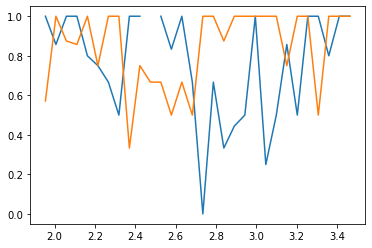

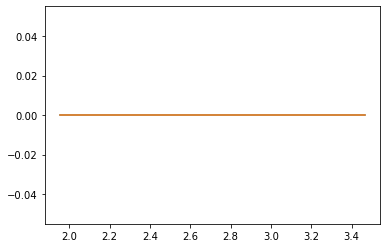

In [7]:
"""
This piece of code is used for the first time to create the dataset required for the subfigure 1b which is variation
of accuracy with frequency of tones. But, after that all the data is stored in the pickle file that is called in the 
next cell. 
"""

def plottingInfluenceFn(tones, behaviour):
    unique_tones = np.arange(np.log10(90), np.log10(3000), np.log10(1003/1000)*40)
    tone_prob_behaviour = np.zeros((len(unique_tones),1))
    numberOfTonesBinned = np.zeros((len(unique_tones),1))

    for i_tone in range(len(tones)):
        closestUniqueTone = np.argmin(np.abs(tones[i_tone]-unique_tones))
        tone_prob_behaviour[closestUniqueTone] += behaviour[i_tone]
        numberOfTonesBinned[closestUniqueTone] += 1 
    return unique_tones, tone_prob_behaviour/numberOfTonesBinned

oneDistractorTrialsDistractorFrequency_low = np.zeros((len(OneDistractor),2))
oneDistractorTrialsDistractorFrequency_high = np.zeros((len(OneDistractor),2))

for itrial in range(len(OneDistractor)):
    if OneDistractor[itrial,4] == 0:
        oneDistractorTrialsDistractorFrequency_low[itrial,0] = OneDistractor[itrial,
                                                                            np.where(OneDistractor[itrial,5:]==0)[0]]
        oneDistractorTrialsDistractorFrequency_low[itrial,1] = OneDistractor[itrial,3]
    else:
        oneDistractorTrialsDistractorFrequency_high[itrial,0] = OneDistractor[itrial,
                                                                            np.where(OneDistractor[itrial,5:]==0)[0]]
        oneDistractorTrialsDistractorFrequency_high[itrial,1] = OneDistractor[itrial,3]

oneDistractorTrialsDistractorFrequency_low_nonzero = oneDistractorTrialsDistractorFrequency_low[np.nonzero(oneDistractorTrialsDistractorFrequency_low[:,0])]
oneDistractorTrialsDistractorFrequency_high_nonzero = oneDistractorTrialsDistractorFrequency_high[np.nonzero(oneDistractorTrialsDistractorFrequency_high[:,0])]
print(OneDistractor.shape,
      oneDistractorTrialsDistractorFrequency_low_nonzero.shape, 
      oneDistractorTrialsDistractorFrequency_high_nonzero.shape)

unique_distractors_low, behaviourGivenDistractor_low = plottingInfluenceFn(oneDistractorTrialsDistractorFrequency_low_nonzero[:,0],
                                                                           oneDistractorTrialsDistractorFrequency_low_nonzero[:,1])
plt.plot(unique_distractors_low, 1-behaviourGivenDistractor_low)
averageBehaviorAcrossSubjects_low = np.append(averageBehaviorAcrossSubjects_low,
                                              1-behaviourGivenDistractor_low,axis=1)

unique_distractors_high, behaviourGivenDistractor_high = plottingInfluenceFn(oneDistractorTrialsDistractorFrequency_high_nonzero[:,0],
                                                                           oneDistractorTrialsDistractorFrequency_high_nonzero[:,1])
plt.plot(unique_distractors_high, behaviourGivenDistractor_high)
averageBehaviorAcrossSubjects_high = np.append(averageBehaviorAcrossSubjects_high,
                                               behaviourGivenDistractor_high,axis=1)

plt.figure()
plt.errorbar(unique_distractors_low, np.mean(averageBehaviorAcrossSubjects_low[:,:isubj+1],axis=1),
            np.std(averageBehaviorAcrossSubjects_low[:,:isubj+1],axis=1)/np.sqrt(isubj+1))
plt.errorbar(unique_distractors_high, np.mean(averageBehaviorAcrossSubjects_high[:,:isubj+1],axis=1),
            np.std(averageBehaviorAcrossSubjects_high[:,:isubj+1],axis=1)/np.sqrt(isubj+1))

isubj += 1 # incremeting the subject counter since we want to include all subjects in a common array for analysis



In [ ]:
fig, ax = plt.subplots(1,1)
ax.errorbar(unique_distractors_low, np.mean(np.array(averageBehaviorAcrossSubjects_low[:,1:]),axis=1),
            np.std(np.array(averageBehaviorAcrossSubjects_low[:,1:]),axis=1)/np.sqrt(56),color='orange')
ax.errorbar(unique_distractors_high, np.mean(np.array(averageBehaviorAcrossSubjects_high[:,1:]),axis=1),
            np.std(np.array(averageBehaviorAcrossSubjects_high[:,1:]),axis=1)/np.sqrt(56),color='brown')
print(isubj)

dict_behaviour = {}
dict_behaviour['unique_distractors_low'] = unique_distractors_low
dict_behaviour['averageBehaviorAcrossSubjects_low'] = averageBehaviorAcrossSubjects_low[:,1:]
dict_behaviour['unique_distractors_high'] = unique_distractors_high
dict_behaviour['averageBehaviorAcrossSubjects_high'] = averageBehaviorAcrossSubjects_high[:,1:]

In [ ]:
import pickle
with open('figures/FromProlific/illustrations/PerformanceAccuracyChangesWithFrequencyOfDistractor.pickle', 'rb') as handle:
    dict_behaviour = pickle.load(handle)

unique_distractors_low = dict_behaviour['unique_distractors_low']
averageBehaviorAcrossSubjects_low = dict_behaviour['averageBehaviorAcrossSubjects_low']
unique_distractors_high = dict_behaviour['unique_distractors_high']
averageBehaviorAcrossSubjects_high = dict_behaviour['averageBehaviorAcrossSubjects_high']
fig, ax = plt.subplots(1,1)
ax.errorbar(unique_distractors_low, np.mean(np.array(averageBehaviorAcrossSubjects_low),axis=1),
            np.std(np.array(averageBehaviorAcrossSubjects_low),axis=1)/np.sqrt(56),color='orange')
ax.errorbar(unique_distractors_high, np.mean(np.array(averageBehaviorAcrossSubjects_high),axis=1),
            np.std(np.array(averageBehaviorAcrossSubjects_high),axis=1)/np.sqrt(56),color='brown')
ax.set_ylim(0,1)
ax.set_xlabel('Frequencies',fontsize=15)
ax.set_ylabel('Probability of Category',fontsize=15)
ax.tick_params(axis='both',labelsize=15)

#plt.savefig('figures/FromProlific/illustrations/PerformanceAccuracyChangesWithFrequencyOfDistractor.png')